# ESN Experiment

This notebook reproduces the results in the paper ...

It consits of three parts:

1. An example for how to set up and experiment and use the code to train an ESN on the data.
2. A section to reproduce the scores mentioned in the paper for each testset.
3. A section to measure training time of an echo state network on our dataset.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import DataSet
import Evaluation
import datetime
import numpy as np 
import matplotlib.pyplot as plt
import random
from matplotlib.backends.backend_pdf import PdfPages

from Utils import *

from DataSet import UniHHIMUGestures
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
def fix_seed(manualSeed):
    
    np.random.seed(manualSeed)
    random.seed(manualSeed)
    torch.manual_seed(manualSeed)
    # if you are using GPU
    torch.cuda.manual_seed(manualSeed)
    torch.cuda.manual_seed_all(manualSeed)


#torch.backends.cudnn.enabled = False 
#torch.backends.cudnn.benchmark = False
#torch.backends.cudnn.deterministic = True

We need to specify a bunch of parameters the expriment:

In [4]:
#===========================================================================
# Give this run a name. 
# If name equals 'test', no log will be generated
#===========================================================================
name = 'test'


#===========================================================================
# Decide which gesture data shall be used for training
#===========================================================================
inputGestures = [0,1,2,3,4,5,6,7,8,9]

#===========================================================================
# Decide which target signals shall be used for training
#===========================================================================
usedGestures = [0,1,2,3,4,5,6,7,8,9]

#===========================================================================
# Concatenate data to create "more" training samples, 1 corresponds to no concatenations
#===========================================================================
concFactor = 1

#===========================================================================
# Add noise to the data, 0 corresponds to no noise. Noise above 2 has shown to weaken recognition
#===========================================================================
noiseFactor = 1

#===========================================================================
# Decide wether gestures shall be shuffled before training. If true, nFolds many 
# pieces will be generated. Not every piece is garanteed to contain every gesture, so do not use too many.
#===========================================================================
shuffle = True
nFolds = 4


#===========================================================================
# Function used to evaluate during cross validation. Possible functions are:
# Evaluation.calc1MinusF1FromMaxApp (best working, used in thesis)
# Oger.utils.nmse (normalised mean square error, tells nothing about classifier perfomance but works okay)
# Evaluation.calcLevenshteinError (use the Levenshtein error, disadvantages are highlighted in thesis) 
# Evaluation.calc1MinusF1FromInputSegment (use segmentation by supervised signal)
#===========================================================================
evaluationFunction = Evaluation.calc1MinusF1FromMaxApp

#===========================================================================
# Set this to true if another output neuron shall be added to represent "no gesture"
#===========================================================================
learnTreshold = False

#===========================================================================
# Use on of the optimisation dictionaries from the optDicts file
#===========================================================================
optDict = 'bestParas'

#===========================================================================
# Use normalizer
#===========================================================================
useNormalized = 2

#===========================================================================
# Pick datasets to train on, and datasets to test on
#===========================================================================
inputFiles = ['stephan','julian','nadja','line']
testFiles = ['nike']

# If desired add a specific file to test on, e.g. randTestFiles = ['lana_0_0.npz']
randTestFiles = []



#===========================================================================
# Setup project directory
#===========================================================================
now = datetime.datetime.now()
resultsPath = getProjectPath()+'results/'
pdfFileName = now.strftime("%Y-%m-%d-%H-%M")+'_'+name+'.pdf'
pdfFilePath = resultsPath+'pdf/'+pdfFileName
npzFileName = now.strftime("%Y-%m-%d-%H-%M")+'_'+name+'.npz'
npzFilePath = resultsPath+'npz/'+npzFileName
bestFlowPath = resultsPath+'nodes/'+now.strftime("%Y-%m-%d-%H-%M")+'_'+name+'.p'
pp = PdfPages(pdfFilePath)


#===========================================================================
# Add labels for gestures
#===========================================================================
totalGestureNames = ['left','right','forward','backward','bounce up','bounce down','turn left','turn right','shake lr','shake ud', \
                     'tap 1','tap 2','tap 3','tap 4','tap 5','tap 6','no gesture']
gestureNames = []
for i in usedGestures:
    gestureNames.append(totalGestureNames[i])
gestureNames.append('no gesture')

Create dataset and dataloaders

In [5]:
def createData(inputFiles, testFiles):
    trainset = UniHHIMUGestures(dataDir='dataSets/', 
                                train=True, 
                                inputFiles=inputFiles,
                                testFiles=testFiles,
                                useNormalized=useNormalized, 
                                learnTreshold=learnTreshold,
                                shuffle=True,
                               )

    testset = UniHHIMUGestures(dataDir='dataSets/', 
                               train=False, 
                               inputFiles=inputFiles,
                               testFiles=testFiles,
                               useNormalized=useNormalized, 
                               learnTreshold=learnTreshold,
                               shuffle=True
                              
                              )

    trainloader = DataLoader(trainset, batch_size=1,
                            shuffle=True, num_workers=1)
    testloader = DataLoader(testset, batch_size=1,
                            shuffle=True, num_workers=1)
    return trainset, testset, trainloader, testloader
    
trainset, testset, trainloader, testloader = createData(inputFiles, testFiles)

Let's take a look at the scaled input data:

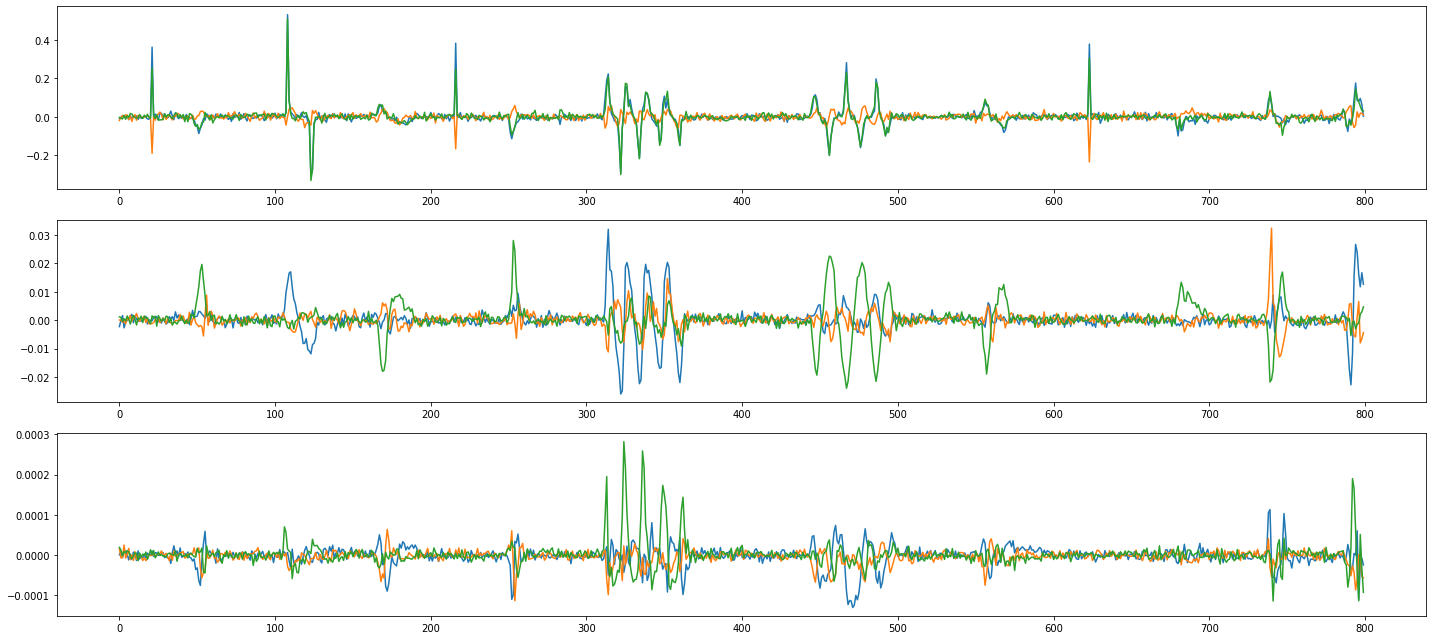

In [6]:
fig, ax = plt.subplots(3,1, figsize=(20,9))
ax[0].plot(trainset[0][0][:800,0:3])
ax[1].plot(trainset[0][0][:800,3:6])
ax[2].plot(trainset[0][0][:800,6:9])
plt.tight_layout()

Looks all good, we can clearly see the gesture sequences intercepted by non gesture seqeuences in between.
Now let's create a Leaky Integrator ESN with parameters as defined in the paper.

In [7]:
from echotorch.nn.ESN import ESN
from echotorch.nn.LiESN import LiESN

fix_seed(0)

def createESN():
    esn = LiESN(
        input_dim=9,
        hidden_dim=400,
        output_dim=10 if not learnTreshold else 11,
        input_scaling=13.,
        sparsity=0.1, # input matrix sparsity
        w_distrib='gaussian',
        spectral_radius=1.,
        bias_scaling=0., # no input bias
        feedbacks=False, # No feedback connections
        learning_algo='inv',
        leaky_rate=.3
    )
    return esn

esn = createESN()

## Training

Training is done automatically when presenting the values and targets to the network. After calling finalize training is completed and network switches to prediction mode.

In [8]:
from torch.autograd import Variable

def trainESN(trainloader, esn):
    for inputs, targets in trainloader:
        inputs, targets = Variable(inputs.float()), Variable(targets.float())
        esn(inputs, targets)

    esn.finalize()


trainESN(trainloader, esn)

## Testing

Plot activations of network on testset and corresponding target signals.

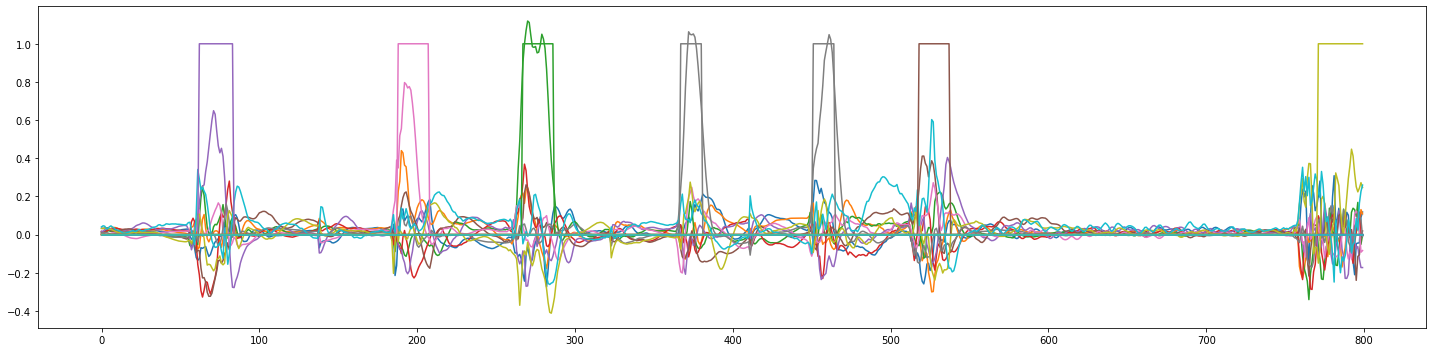

In [9]:
for test_inputs, test_targets in testloader:
    plt.figure(figsize=(20,5))
    outputs = esn(test_inputs.float())
    if learnTreshold:
        plt.plot(outputs[0,:800,10], c='black')
    plt.plot(outputs[0,:800,:10])
    plt.plot(test_targets[0,:800,:])
plt.tight_layout()

In [10]:
import sklearn

def testESN(esn, testloader, learnTreshold, fixed_threshold=0.4, plot=False, conf_mat_title="", testFiles=""):
    
    testCms = []
    testF1MaxApps = []
    testAccuracies = []

    for test_inputs, test_targets in testloader:
        outputs = esn(test_inputs.float())
    
        
        t_target = test_targets[0].numpy()
        prediction = outputs[0].numpy()[:,:10]
        if learnTreshold: # if threshold is learned, then it's the last collumn of the prediction
            threshold = outputs[0].numpy()[:,10]
        else: #else add a constant threshold
            threshold = np.ones((prediction.shape[0],1))*fixed_threshold

        t_maxApp_prediction = Evaluation.calcMaxActivityPrediction(prediction,t_target,threshold, 10)


        pred_MaxApp, targ_MaxApp = Evaluation.calcInputSegmentSeries(t_maxApp_prediction, t_target, 0.5)
        testF1MaxApps.append(np.mean(sklearn.metrics.f1_score(targ_MaxApp,pred_MaxApp,average=None)))
        testAccuracies.append(np.mean(sklearn.metrics.accuracy_score(targ_MaxApp,pred_MaxApp)))
        
        
        if plot:
            plt.figure(figsize=(20,3))
            plt.plot(t_maxApp_prediction[:800])
            plt.plot(t_target[:800])


        conf = sklearn.metrics.confusion_matrix(targ_MaxApp, pred_MaxApp)
        testCms.append(conf)

        if plot:
            Evaluation.plot_confusion_matrix(testCms[0], gestureNames, title=conf_mat_title)
            plt.tight_layout()
            plt.ylim(10.5,-0.5)

        print("Test f1 score for maxactivity algorithm on testsets {} is {:.2f}, accuracy {:.2} ".format(
            testFiles, np.mean(testF1MaxApps), np.mean(testAccuracies)))
    return testF1MaxApps, testAccuracies, testCms

f1scores, accuracies, testCms = testESN(esn, testloader, learnTreshold)


Test f1 score for maxactivity algorithm on testsets  is 0.80, accuracy 0.87 


In [11]:
testCms

[array([[ 10,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   3,   0,   0,   0,   1,   4,   0,   1,   0,   1],
        [  0,   0,  10,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,  10,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,  10,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   1,   5,   1,   0,   0,   3,   1],
        [  0,   0,   0,   0,   0,   0,  10,   0,   0,   0,   0],
        [  1,   0,   0,   0,   0,   0,   0,   9,   0,   0,   0],
        [  0,   3,   0,   0,   0,   0,   0,   0,   7,   1,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,  10,   0],
        [  1,   0,   0,   1,   1,   3,   0,   0,   3,   1, 101]])]

## Section 2: Evaluate on different Test Sets

In [12]:
fix_seed(1)

files = ['stephan','julian','nadja','line','nike']

all_scores = []
all_train_scores = []
all_networks = []
all_accuracies = []
all_cms = []

for idx in range(5):
    scores = []
    train_scores = []
    accuracies = []
    networks = []
    cms = []
    
    # Shuffle testsets
    inputFiles = files[:idx] + files[idx+1:]
    testFiles = files[idx:idx+1]


    for _ in range(20):
        trainset, testset, trainloader, testloader = createData(inputFiles=inputFiles, testFiles=testFiles)
        esn = createESN()
        trainESN(trainloader, esn)
        
        if False:
            totalTrainInputData = []
            totalTrainTargetData = []
            for inputs, targets in trainloader:
                totalTrainInputData.append(inputs)
                totalTrainTargetData.append(targets)
            totalTrainInputData = torch.cat(totalTrainInputData,1)
            totalTrainTargetData = torch.cat(totalTrainTargetData,1)
            totalTrainInputData = torch.tensor(totalTrainInputData)
            totalTrainPrediction = esn(totalTrainInputData.float())

            totalTrainPrediction = totalTrainPrediction[0,:,:].numpy()
            totalTrainTargetData = totalTrainTargetData[0,:,:].numpy()
        
            tresholds, _, bestF1ScoreTreshold = Evaluation.calcTPFPForThresholds(
                totalTrainPrediction, totalTrainTargetData, 'Train Data Confusion - Target Treshold', False, plot=False)
        bestF1ScoreTreshold = 0.4
        # very good results when bestF1score is set to 0.4
        
        train_score, train_accuracy, train_cms = testESN(esn, trainloader, learnTreshold, 
                              fixed_threshold=bestF1ScoreTreshold)
        score, accuracy, cm = testESN(esn, testloader, learnTreshold, 
                        fixed_threshold=bestF1ScoreTreshold, testFiles=testFiles)
        train_scores.extend(train_score)
        scores.extend(score)
        accuracies.extend(accuracy)
        networks.append(esn)
        cms.extend(cm)
    print('{}: avg f1 score: {:.2f} ({:.2f}) '.format(testFiles[0], np.array(scores).mean(),np.array(scores).std()))
    all_scores.append(scores)
    all_train_scores.append(train_scores)
    all_accuracies.append(accuracies)
    all_networks.append(networks)
    all_cms.append(cms)

Test f1 score for maxactivity algorithm on testsets  is 0.98, accuracy 0.98 
Test f1 score for maxactivity algorithm on testsets  is 0.98, accuracy 0.99 
Test f1 score for maxactivity algorithm on testsets  is 0.98, accuracy 0.98 
Test f1 score for maxactivity algorithm on testsets  is 0.96, accuracy 0.97 
Test f1 score for maxactivity algorithm on testsets ['stephan'] is 0.83, accuracy 0.9 
Test f1 score for maxactivity algorithm on testsets  is 0.96, accuracy 0.97 
Test f1 score for maxactivity algorithm on testsets  is 0.95, accuracy 0.96 
Test f1 score for maxactivity algorithm on testsets  is 0.95, accuracy 0.96 
Test f1 score for maxactivity algorithm on testsets  is 0.96, accuracy 0.97 
Test f1 score for maxactivity algorithm on testsets ['stephan'] is 0.76, accuracy 0.85 
Test f1 score for maxactivity algorithm on testsets  is 0.94, accuracy 0.97 
Test f1 score for maxactivity algorithm on testsets  is 0.95, accuracy 0.97 
Test f1 score for maxactivity algorithm on testsets  is

/home/stephan/miniconda3/envs/BA_Analysis_torch/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Test f1 score for maxactivity algorithm on testsets ['stephan'] is 0.70, accuracy 0.83 
Test f1 score for maxactivity algorithm on testsets  is 1.00, accuracy 1.0 
Test f1 score for maxactivity algorithm on testsets  is 0.99, accuracy 0.99 
Test f1 score for maxactivity algorithm on testsets  is 0.98, accuracy 0.98 
Test f1 score for maxactivity algorithm on testsets  is 0.98, accuracy 0.98 
Test f1 score for maxactivity algorithm on testsets ['stephan'] is 0.83, accuracy 0.87 
Test f1 score for maxactivity algorithm on testsets  is 0.97, accuracy 0.97 
Test f1 score for maxactivity algorithm on testsets  is 0.95, accuracy 0.96 
Test f1 score for maxactivity algorithm on testsets  is 0.95, accuracy 0.96 
Test f1 score for maxactivity algorithm on testsets  is 0.96, accuracy 0.97 
Test f1 score for maxactivity algorithm on testsets ['stephan'] is 0.91, accuracy 0.93 
Test f1 score for maxactivity algorithm on testsets  is 0.98, accuracy 0.98 
Test f1 score for maxactivity algorithm on t

Test f1 score for maxactivity algorithm on testsets  is 0.97, accuracy 0.98 
Test f1 score for maxactivity algorithm on testsets ['julian'] is 0.70, accuracy 0.82 
Test f1 score for maxactivity algorithm on testsets  is 0.97, accuracy 0.98 
Test f1 score for maxactivity algorithm on testsets  is 0.97, accuracy 0.97 


KeyboardInterrupt: 

In [ ]:
print("""Total results: 
    Avg train score: {:.2f} ({:.2f}), 
    avg test score: {:.2f} ({:.2f}), 
    acc: {:.2f} ({:.2f})""".format(
    np.array(all_train_scores).mean(), 
    np.array(all_train_scores).std(), 
    np.array(all_scores).mean(),
    np.array(all_scores).std(), 
    np.array(accuracies).mean(), 
    np.array(accuracies).std(),
))



results = np.hstack([
        np.array(all_train_scores).mean(1, keepdims=True), 
        np.array(all_train_scores).std(1, keepdims=True), 
        np.array(all_scores).mean(1, keepdims=True),
        np.array(all_scores).std(1, keepdims=True), 
        np.array(all_accuracies).mean(1, keepdims=True),
])

for file, result in zip(files, results):
    print("{}: Avg train score: {:.2f} ({:.2f}), avg test score: {:.2f} ({:.2f}) acc: {:.2f}".format(file, *result))
    


In [22]:
(np.mean([0.624 - 0.62, 0.791 - 0.79, 0.809 - 0.78, 0.831 - 0.76, 0.926 - 0.88]),
np.mean([0.624 - 0.60, 0.791 - 0.79, 0.809 - 0.80, 0.831 - 0.76, 0.926 - 0.86]),)


print("paper mean:           {:.3f}".format(np.mean([0.624,0.791,0.809,0.831,0.926])))

print("paper reproduct mean: {:.3f}".format(np.mean([0.59,0.74,0.77,0.79,0.86])))
print("opti. threshold mean: {:.3f}".format(np.mean([0.60,0.79,0.80,0.76,0.86])))
print("fixed threshold mean: {:.3f}".format(np.mean([0.62,0.79,0.78,0.76,0.88])))
print("seed 1          mean: {:.3f}".format(np.mean([0.64,0.82,0.77,0.81,0.90])))
print("seed 1 (loc)    mean: {:.3f}".format(np.mean([0.62,0.81,0.77,0.79,0.88])))


paper mean:           0.796
paper reproduct mean: 0.750
opti. threshold mean: 0.762
fixed threshold mean: 0.766
seed 1          mean: 0.788
seed 1 (loc)    mean: 0.774


| Test Person   | Paper   | Paper Repro   | loc fix seed 1| loc fix seed 1 train | 
| ------------- |:-------:| :-----------: | :------------:|                      |
| Julian        | 0.624   | 0.59 (0.04)   | 0.62 (0.05)   | 0.64 (0.04)          |
| Nike          | 0.791   | 0.74 (0.05)   | 0.81 (0.04)   | 0.81 (0.05)          |
| Stephan       | 0.809   | 0.77 (0.03)   | 0.77 (0.04)   | 0.80 (0.05)          |
| Nadja         | 0.831   | 0.79 (0.04)   | 0.79 (0.05)   | 0.80 (0.06)          |
| Line          | 0.926   | 0.86 (0.03)   | 0.88 (0.05)   | 0.88 (0.05)          |
| ------------- |---------| ------------- |               |                      |
| Diff paper    |         |               |               |                      |
| Mean          | 0.796   | 0.75          |               |                      |



Results in comparison:

| Test Person   | Paper   | Paper Repro   | Opt. Treshold | Fixed Treshold | fixed seed 1   |loc fix seed 1| 
| ------------- |:-------:| :-----------: | :-----------: | :------------: | :------------: |:------------:|
| Julian        | 0.624   | 0.59 (0.04)   | 0.60 (0.04)   | 0.62 (0.04)    | 0.64 (0.05)    | 0.62 (0.05)  |
| Nike          | 0.791   | 0.74 (0.05)   | 0.79 (0.03)   | 0.79 (0.04)    | 0.82 (0.04)    | 0.81 (0.04)  |
| Stephan       | 0.809   | 0.77 (0.03)   | 0.80 (0.03)   | 0.78 (0.04)    | 0.77 (0.06)    | 0.77 (0.04)  |
| Nadja         | 0.831   | 0.79 (0.04)   | 0.76 (0.06)   | 0.76 (0.04)    | 0.81 (0.04)    | 0.79 (0.05)  |
| Line          | 0.926   | 0.86 (0.03)   | 0.86 (0.03)   | 0.88 (0.04)    | 0.90 (0.05)    | 0.88 (0.05)  |
| ------------- |---------| ------------- | ------------- | ---------------| ---------------|              |
| Diff paper    |         |               | 0.034         | 0.030          | ---------------|              |
| Mean          | 0.796   | 0.75          | 0.762         | 0.766          | 0.788          |              |

#### TODO: why is the testscore here lower than in OGER? supposed to be 0.8

In [45]:
eval_models = {}
eval_scores = {}
for i, (testfile, scores, networks) in enumerate(zip(files, all_scores,all_networks)):
    print(i, testfile)
    # get median model
    median_idx = np.argsort(scores)[len(scores)//2]
    median_score = scores[median_idx]
    median_network = networks[median_idx]
    eval_models[testfile] = median_network
    eval_scores[testfile] = median_score
median_network

0 stephan
1 julian
2 nadja
3 line
4 nike


LiESN(
  (output): RRCell(
    (softmax): Softmax(dim=2)
  )
  (esn_cell): LiESNCell()
)

Test f1 score for maxactivity algorithm on testsets  is 0.80, accuracy 0.88 


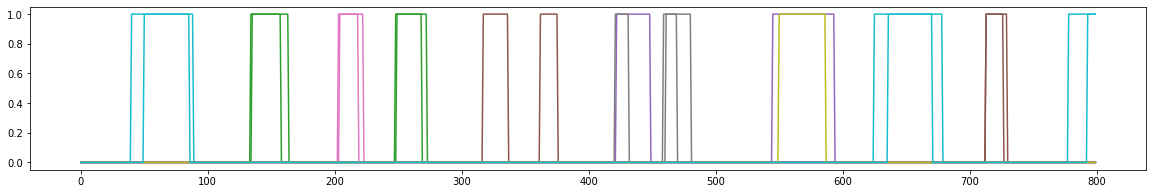

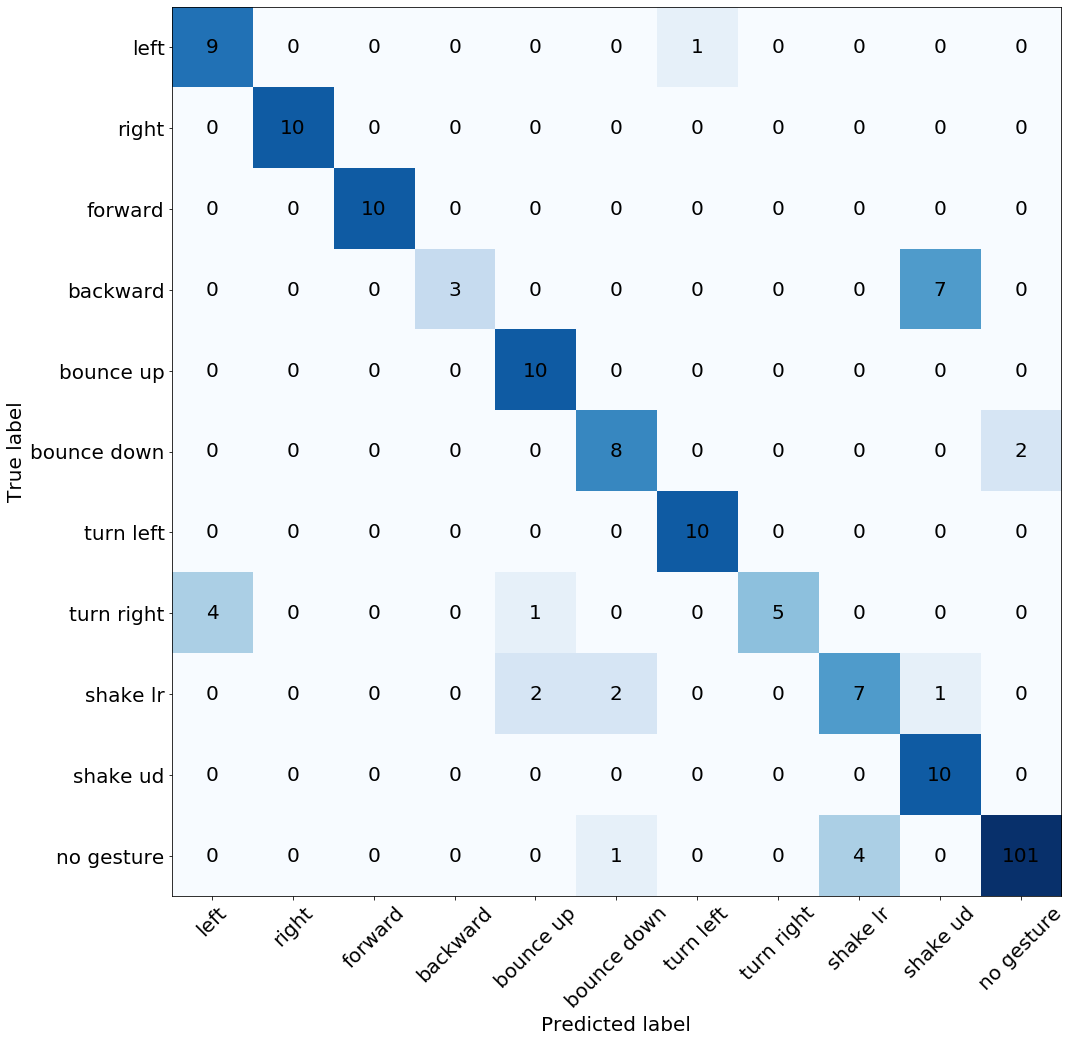

Test f1 score for maxactivity algorithm on testsets  is 0.62, accuracy 0.76 


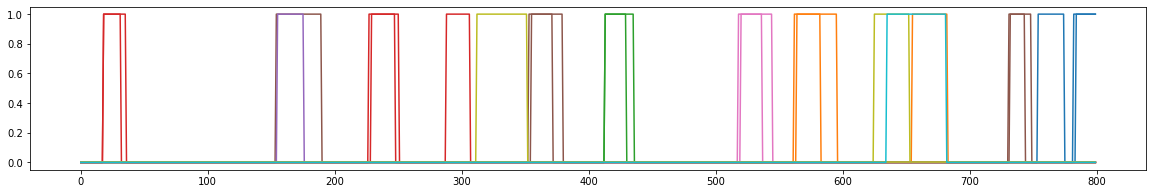

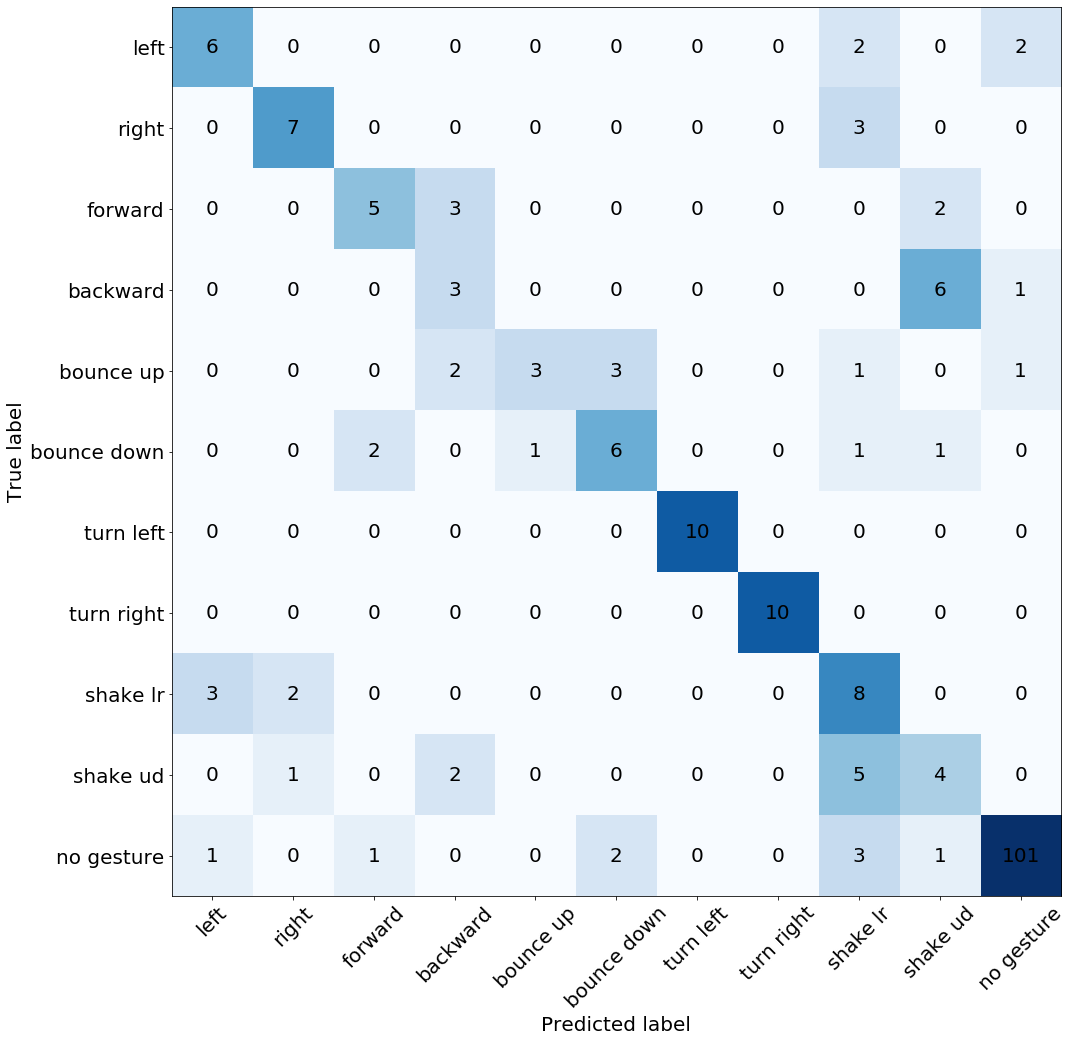

Test f1 score for maxactivity algorithm on testsets  is 0.75, accuracy 0.84 


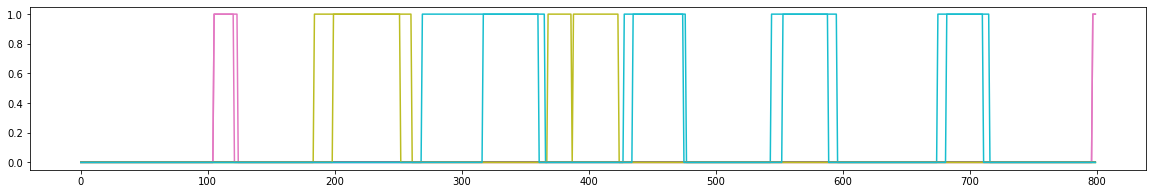

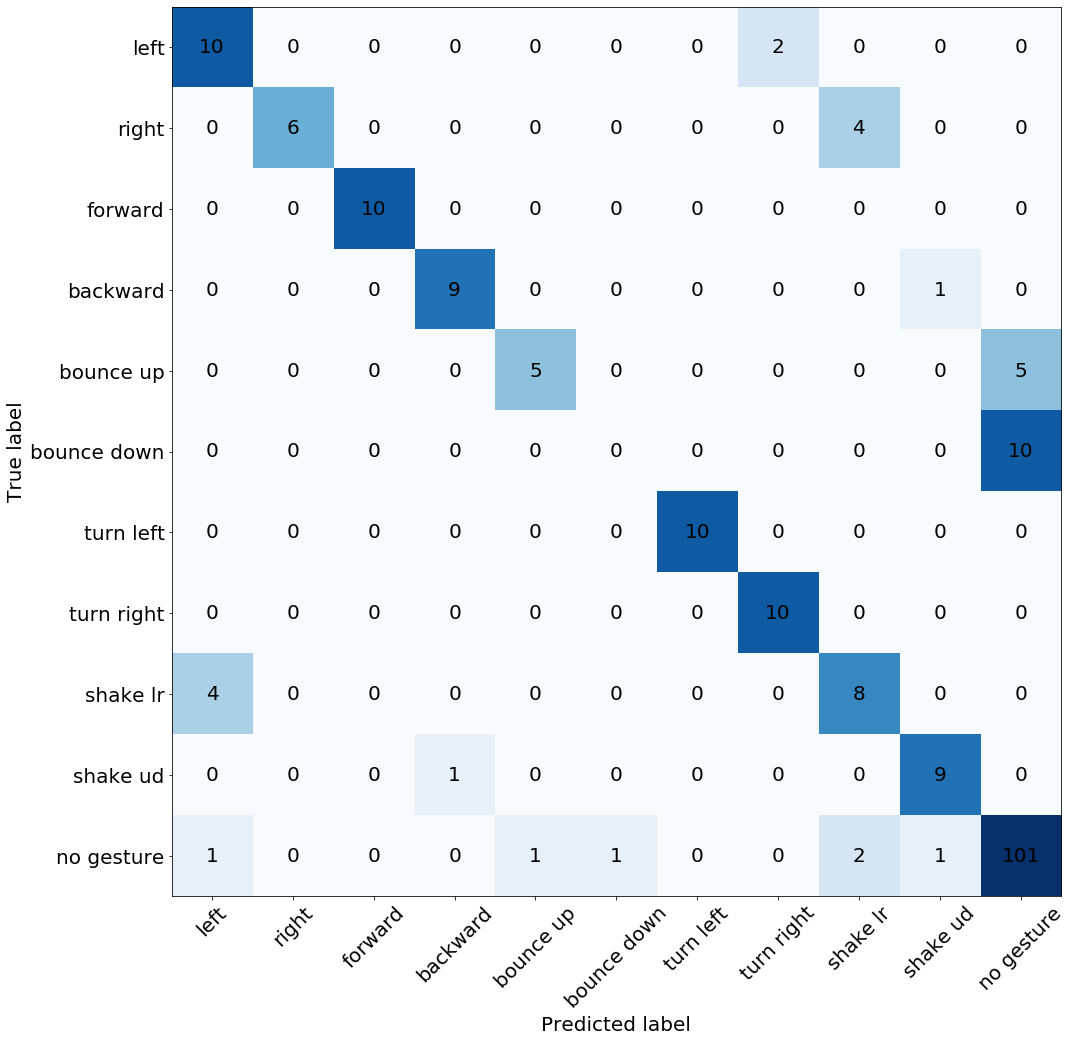

Test f1 score for maxactivity algorithm on testsets  is 0.94, accuracy 0.95 


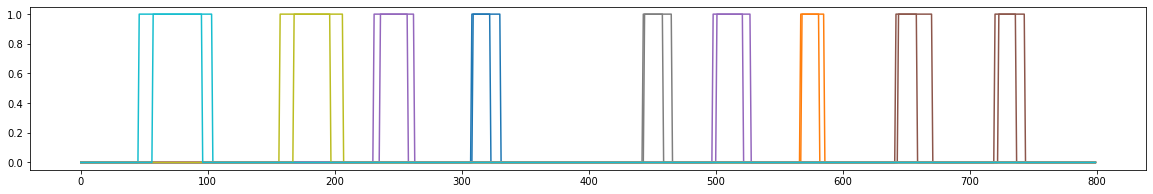

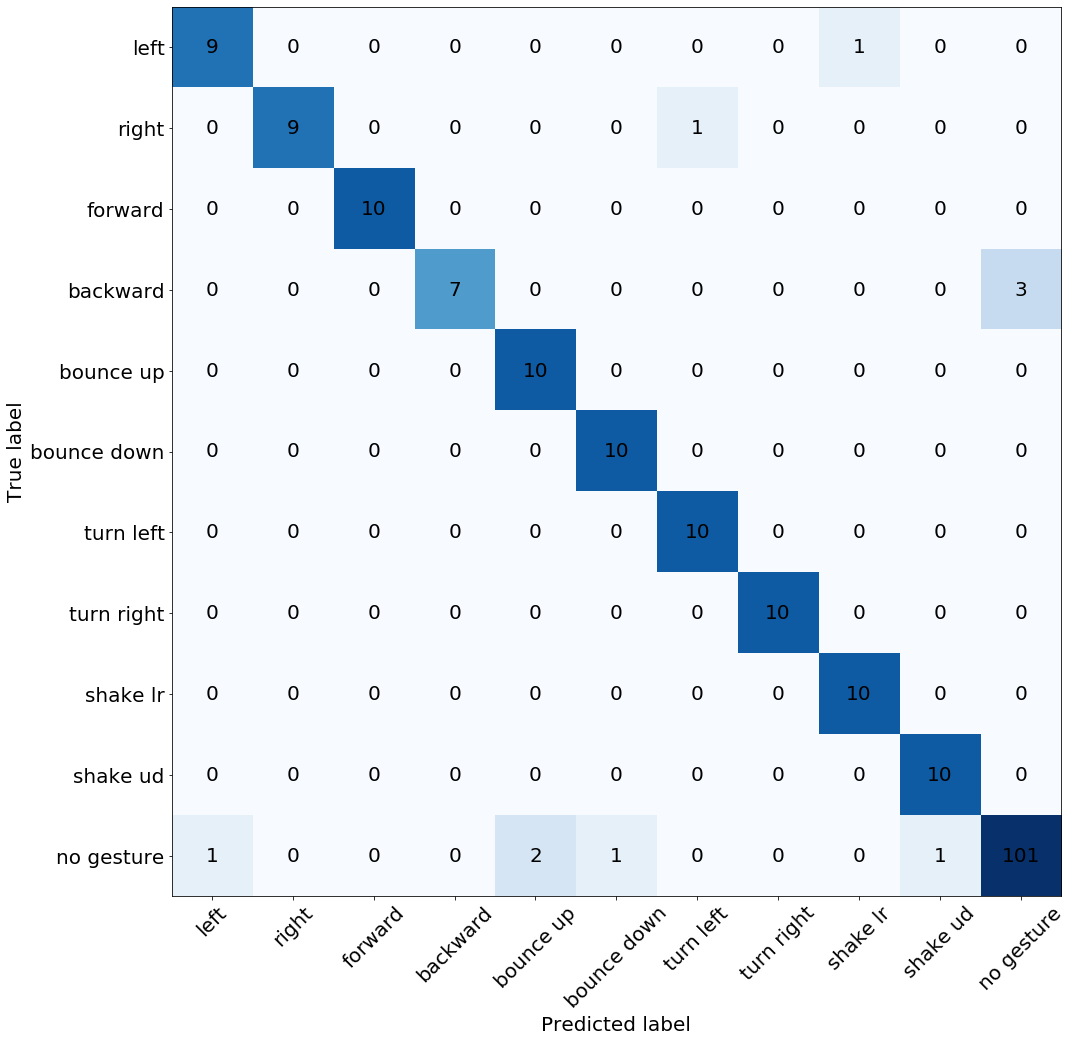

Test f1 score for maxactivity algorithm on testsets  is 0.78, accuracy 0.85 


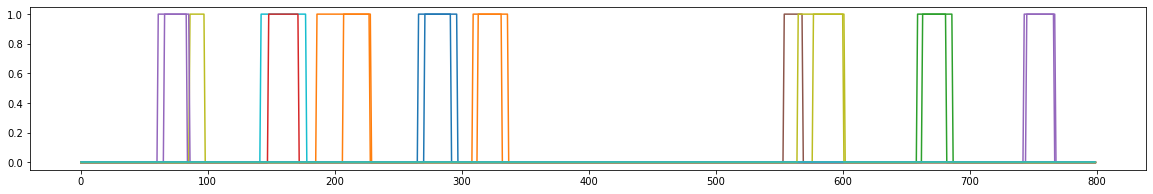

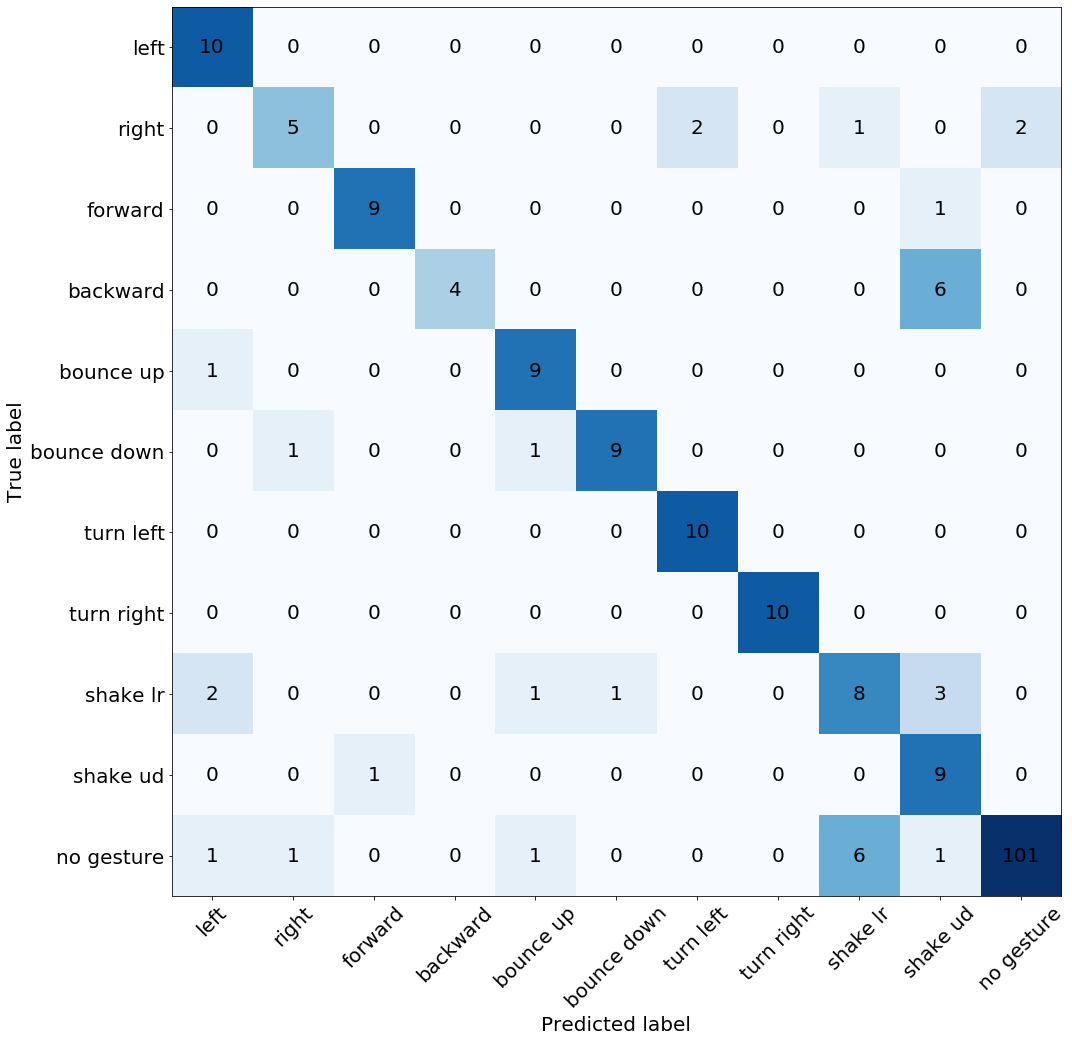

In [47]:
import matplotlib
#matplotlib.rcParams.update({'font.size': 20})
     
fix_seed(1)

for key in eval_models.keys():
    
    trainset, testset, trainloader, testloader = createData(set(files) - set([key]), [key])
    score, accuracy, _ = testESN(eval_models[key], testloader, learnTreshold, fixed_threshold=0.4, 
                    plot=True, conf_mat_title='')

    plt.subplots_adjust(bottom=0.1)
    pp = PdfPages('figures/esn_experiment_{}_f1_score_{:.2f}.pdf'.format(key, score[0]))
    pp.savefig()
    plt.savefig('figures/esn_experiment_{}_f1_score_{:.2f}.eps'.format(key, score[0]), format='eps')

    plt.pause(0.1)
    pp.close()

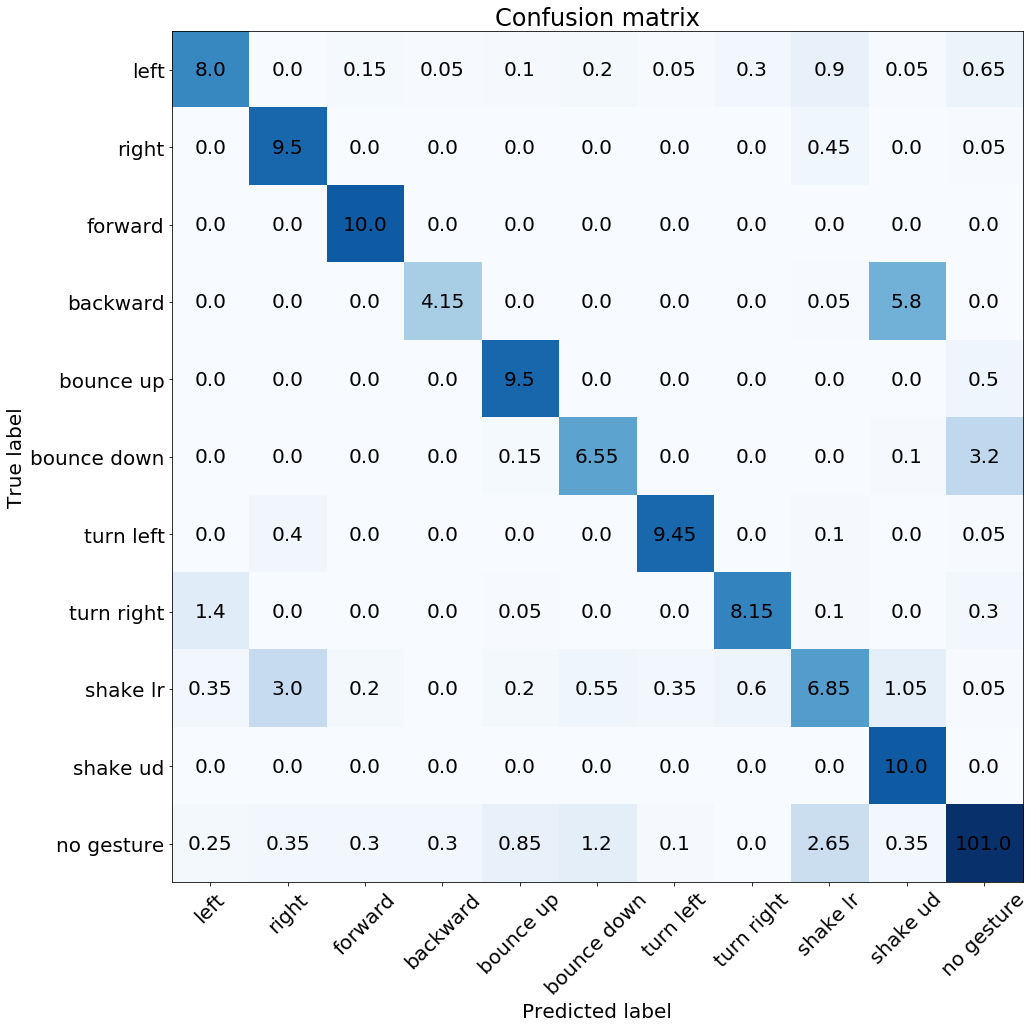

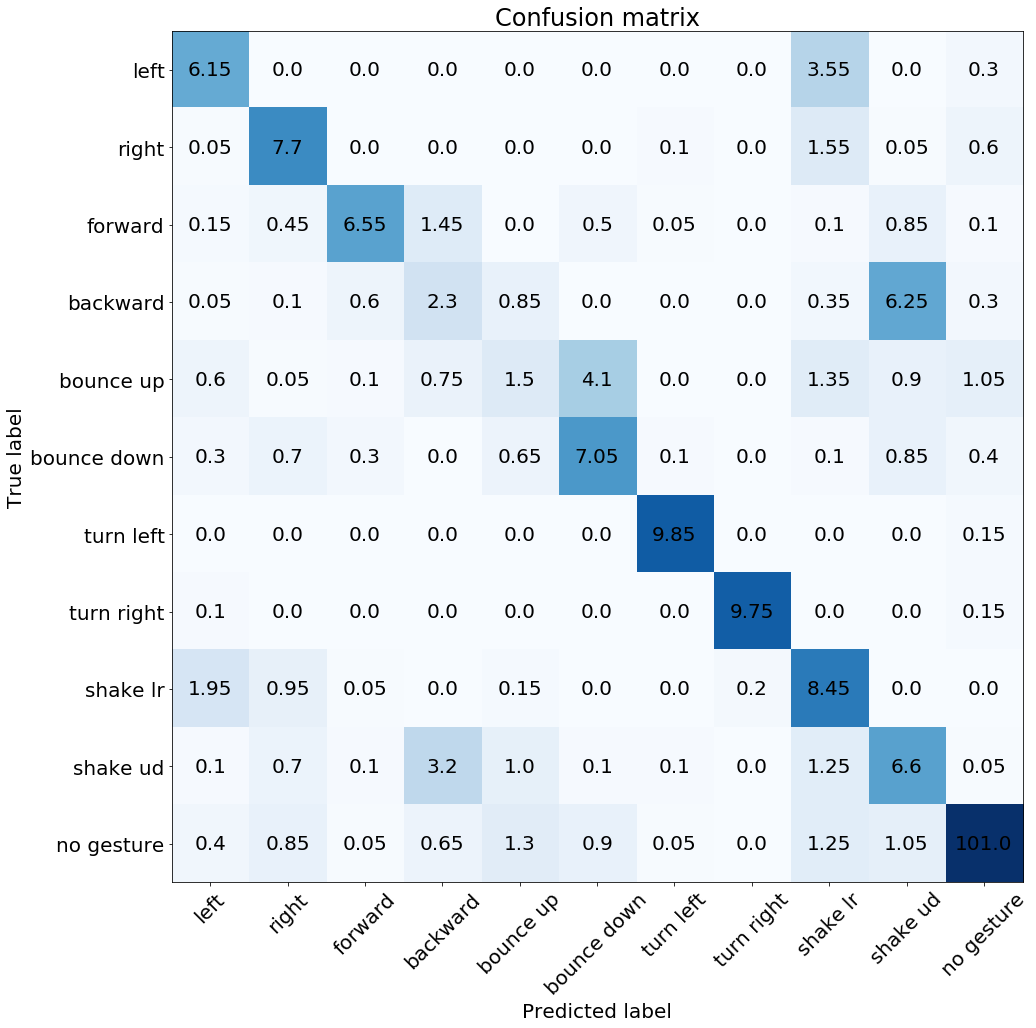

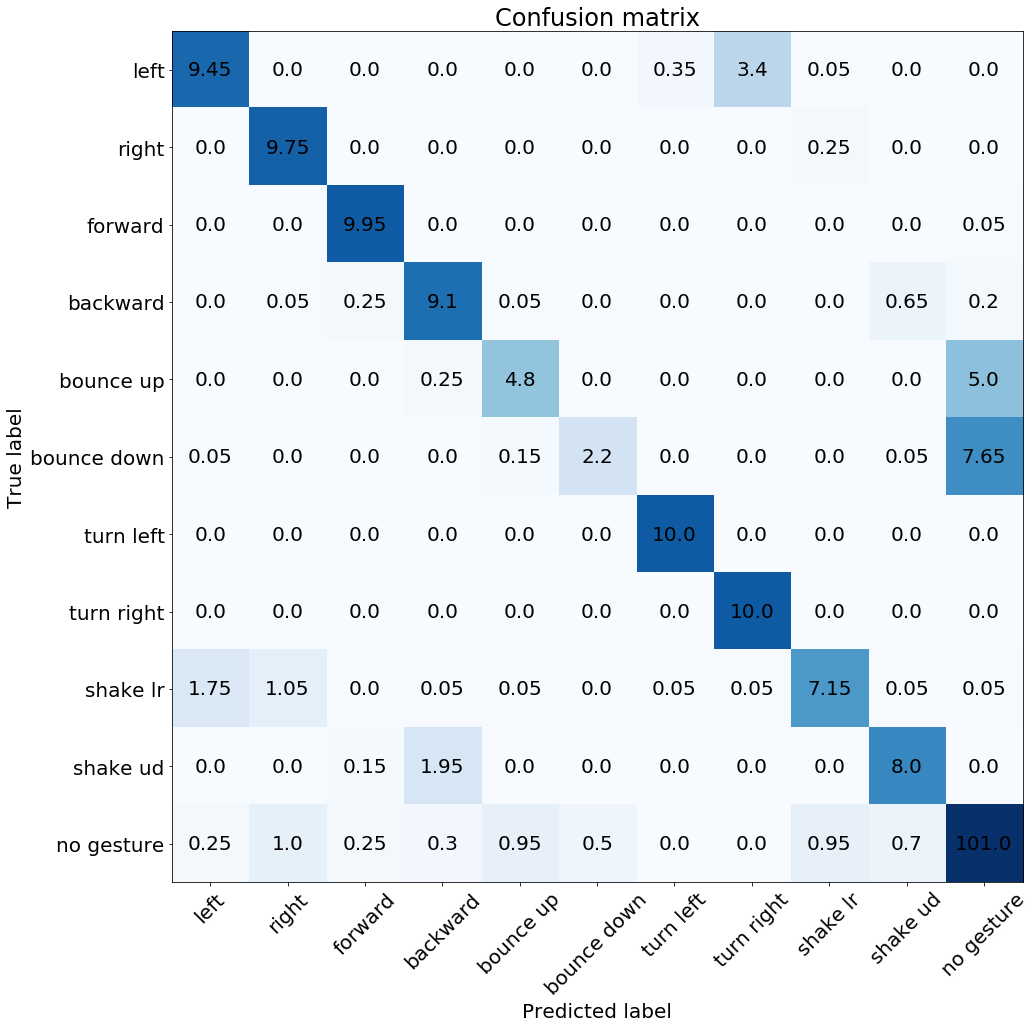

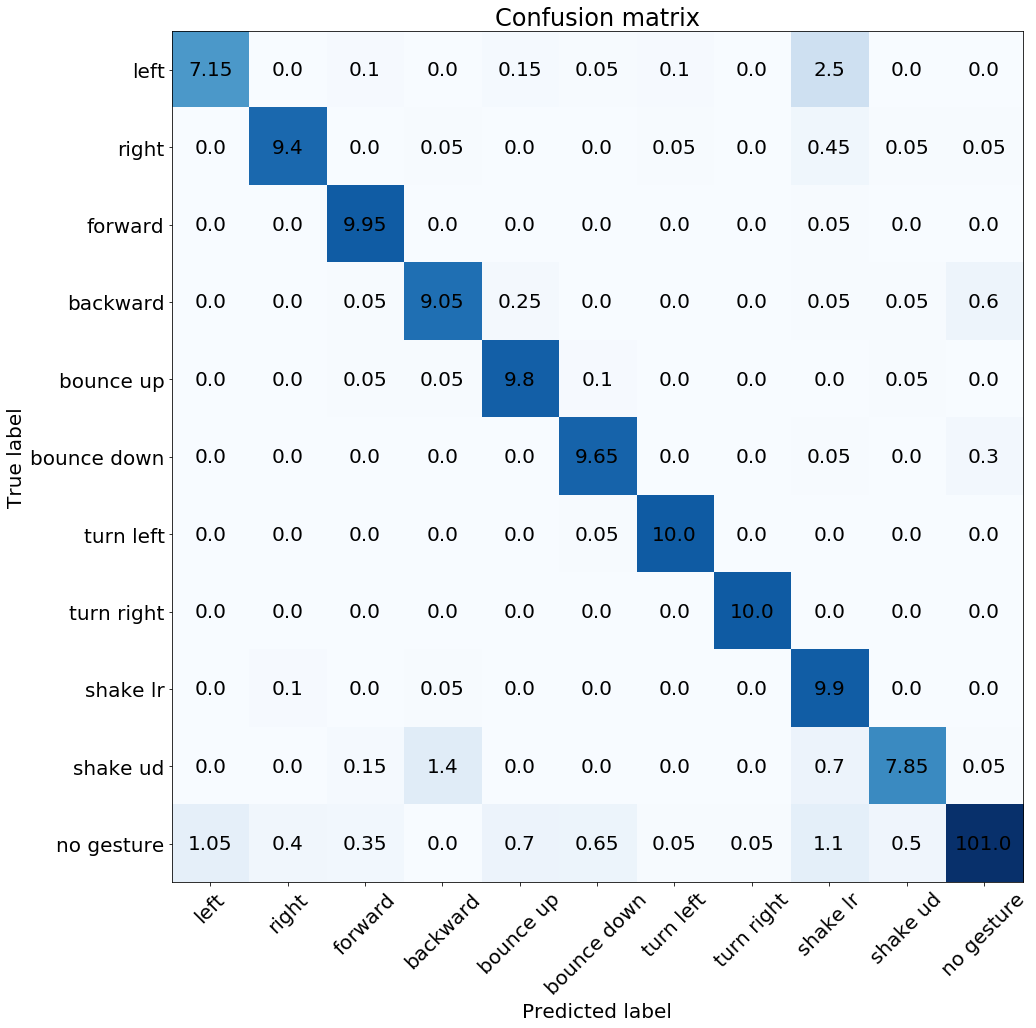

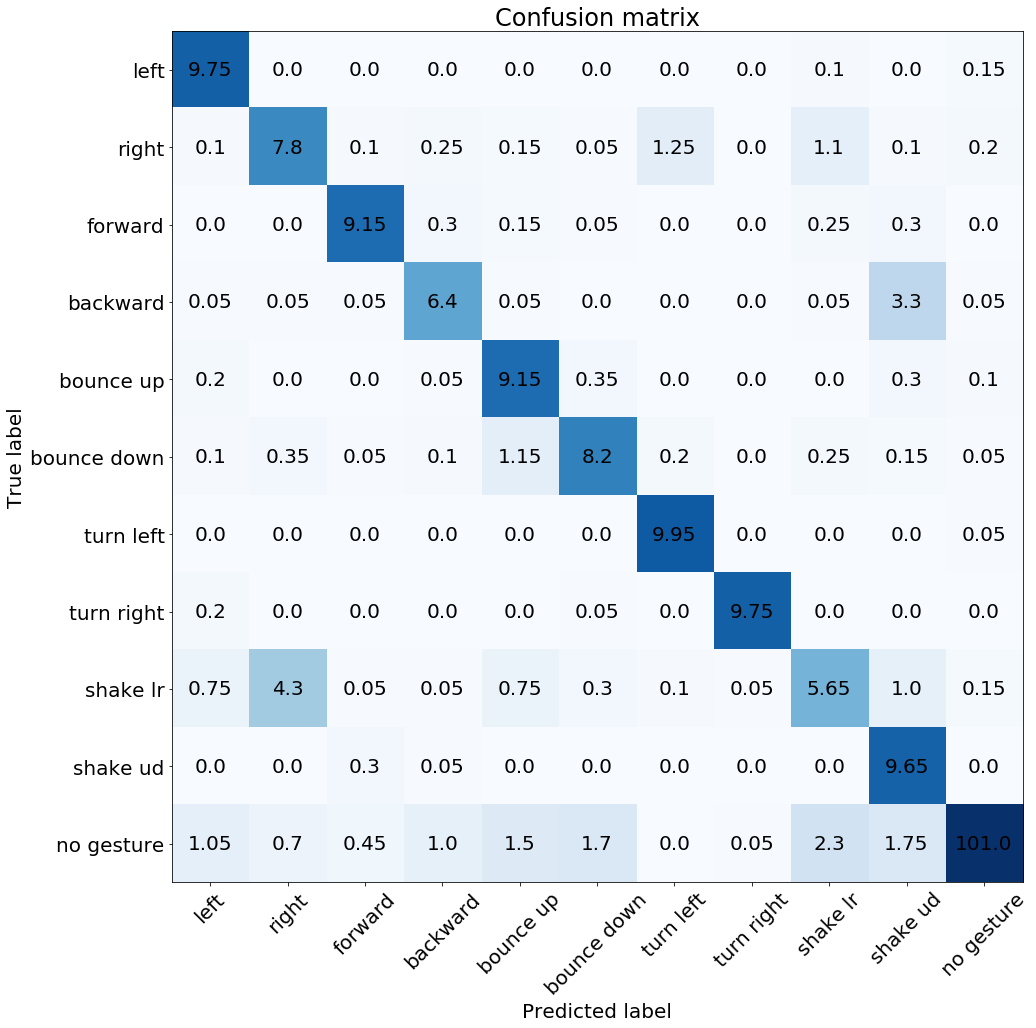

In [48]:
from Evaluation import plot_confusion_matrix

for i, (testfile, scores, cms) in enumerate(zip(files, all_scores,np.array(all_cms))):
    fig = plot_confusion_matrix(cms.mean(0), gestures=totalGestureNames[:10] + totalGestureNames[-1:])
    plt.xlim(-0.5, 10.5)
    plt.ylim(10.5, -0.5)
    fig.tight_layout(pad=3.0)
    pp = PdfPages('figures/esn_experiment_{}_avg_f1_score_{:.2f}.pdf'.format(testfile, np.mean(scores)))
    pp.savefig()
    pp.close()
    plt.savefig('figures/esn_experiment_{}_avg_f1_score_{:.2f}.eps'.format(testfile, np.mean(scores)), format='eps')


## Section 3: Meassure training time

We are using timeit to meassure training time, two repetitions of 10 loops.

In [14]:
print("Training on: {}".format(inputFiles))

Training on: ['stephan', 'julian', 'nadja', 'line']


In [15]:
%%timeit -r2 -n10 
esn = createESN()
trainESN(trainloader, esn)

3.57 s ± 30.6 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)


# Experimental code

Code below here is experimental and not used in the paper

#### Try out softmax

Learn threshold must be true for softmax to make sense.

In [16]:
assert learnTreshold==True, 'Model must be created with learnThreshold=true to use softmax'

for test_inputs, test_targets in testloader:
    plt.figure(figsize=(20,5))
    outputs = esn(test_inputs.float())
    outputs = nn.Softmax(2)(outputs)
    if learnTreshold:
        plt.plot(outputs[0,:800,10], c='black')
    plt.plot(outputs[0,:800,:10])
    plt.plot(test_targets[0,:800,:])
plt.tight_layout()

AssertionError: Model must be created with learnThreshold=true to use softmax

In [ ]:

def calcBasicMaxActivation(prediction, t_target, threshold, gestureMinLength=1 ):
    inactive_timesteps = prediction.max(1) < threshold
    active_timesteps = prediction.max(1) >= threshold

    gesture_end = inactive_timesteps[1:] * active_timesteps[:-1]
    gesture_start = inactive_timesteps[:-1] * active_timesteps[1:]

    predicted_labels = np.zeros(prediction.shape)
    for start, end in list(zip(np.where(gesture_start)[0], np.where(gesture_end)[0])):

        if end-start > gestureMinLength:
            gestureclass = prediction[start:end].sum(0).argmax()
            predicted_labels[start:end,gestureclass] = 1
    return predicted_labels


In [ ]:
import sklearn
testCms = []
testF1MaxApps = []

t_target =  test_targets[0].numpy()
prediction = outputs[0].numpy()[:,:10]
if learnTreshold: # if threshold is learned, then it's the las collumn of the prediction
    threshold = outputs[0].numpy()[:,10]
else: #else add a constant threshold
    threshold = np.ones((prediction.shape[0],1))*0.4

# use different method for maxappactivation
t_maxApp_prediction = calcBasicMaxActivation(prediction,t_target,threshold, 10)


pred_MaxApp, targ_MaxApp = Evaluation.calcInputSegmentSeries(t_maxApp_prediction, t_target, 0.5)
testF1MaxApps.append(np.mean(sklearn.metrics.f1_score(targ_MaxApp,pred_MaxApp,average=None)))


#print(t_maxApp_prediction.shape, prediction.shape, pred_MaxApp, targ_MaxApp)
plt.figure(figsize=(20,3))
plt.plot(t_maxApp_prediction[:800])
plt.plot(t_target[:800])


conf = sklearn.metrics.confusion_matrix(targ_MaxApp, pred_MaxApp)
testCms.append(conf)

Evaluation.plot_confusion_matrix(testCms[0], gestureNames, 'test set')
plt.tight_layout()
plt.ylim(10.5,-0.5)

print("Test f1 score for maxactivity: {:.2f}, reg: {:.2f}".format(testF1MaxApps[0], trainF1s[0]))


